In [21]:
library(tidyverse)
library(repr)
library(tidymodels)

In [22]:
# Load players dataset into notebook
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [23]:
# Wrangle data so there are no values with 'NA'
players <- players |>
  filter(!is.na(Age)) |>
  filter(!is.na(played_hours))

The data is in tidy format, as each row depicts a single observation (a unique player), each column represents a single variable (age, name, etc.), and each cell contains a single value.

In [27]:
# Selecting for variables of interest
players_data <- players |>
    select(played_hours, Age)

In [55]:
# Calculating summary statistics for variables of interest
# NOTE: MAYBE ADD IQR??
played_hours_summary <- players |>
    summarise(
        played_hours_mean = mean(played_hours),
        played_hours_median = median(played_hours),
        played_hours_range = max(played_hours) - min(played_hours),
        played_hours_sd = sd(played_hours)) |>
        round(2)
played_hours_summary

age_summary <- players |>
    summarise(
        age_mean = mean(Age),
        age_median = median(Age),
        age_range = max(Age) - min(Age),
        age_sd = sd(Age)) |>
        round(2)
age_summary


played_hours_mean,played_hours_median,played_hours_range,played_hours_sd
<dbl>,<dbl>,<dbl>,<dbl>
5.9,0.1,223.1,28.5


age_mean,age_median,age_range,age_sd
<dbl>,<dbl>,<dbl>,<dbl>
21.14,19,49,7.39


## **graph below shows no real trend, comment on this**

#### Figure 1: Scatterplot showing the relationship between Age and Hours Played with trend line

`geom_smooth()` using formula = 'y ~ x'


$x
[1] "Player Age (years)"

$y
[1] "Time Played (hours)"

$title
[1] "Relationship Between Age and Hours Played"

attr(,"class")
[1] "labels"

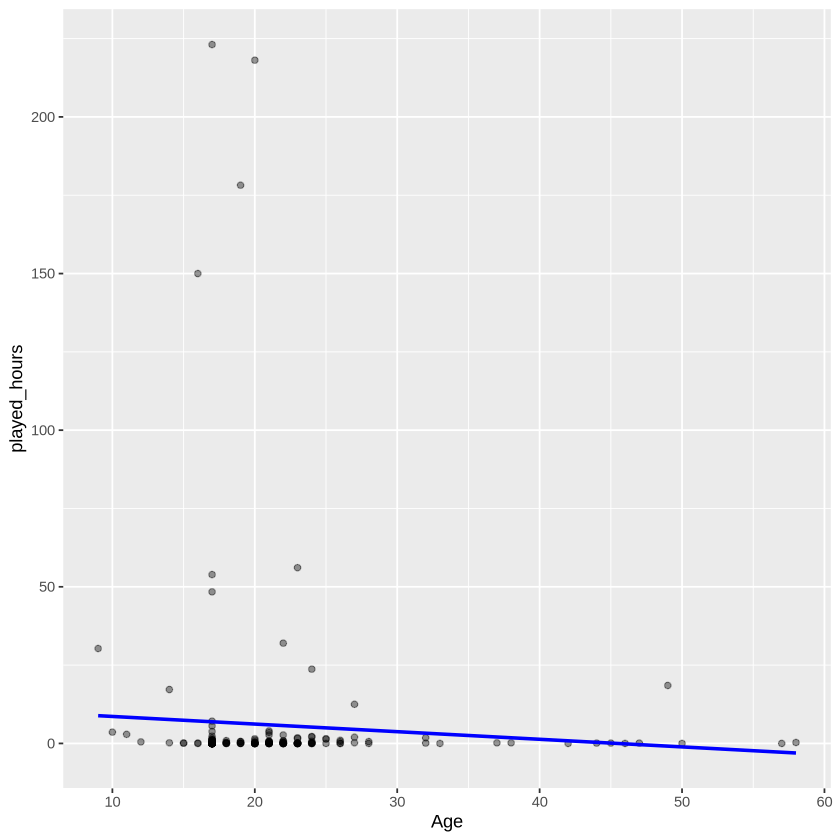

In [59]:
ggplot(players, aes(x=Age, y=played_hours))+
       geom_point(alpha = 0.4) +
       geom_smooth(method = "lm", se = FALSE, colour = "blue")
       labs(title = "Relationship Between Age and Hours Played",
            x = "Player Age (years)",
            y = "Time Played (hours)")

#### Figure 2: Distribution of Player Ages

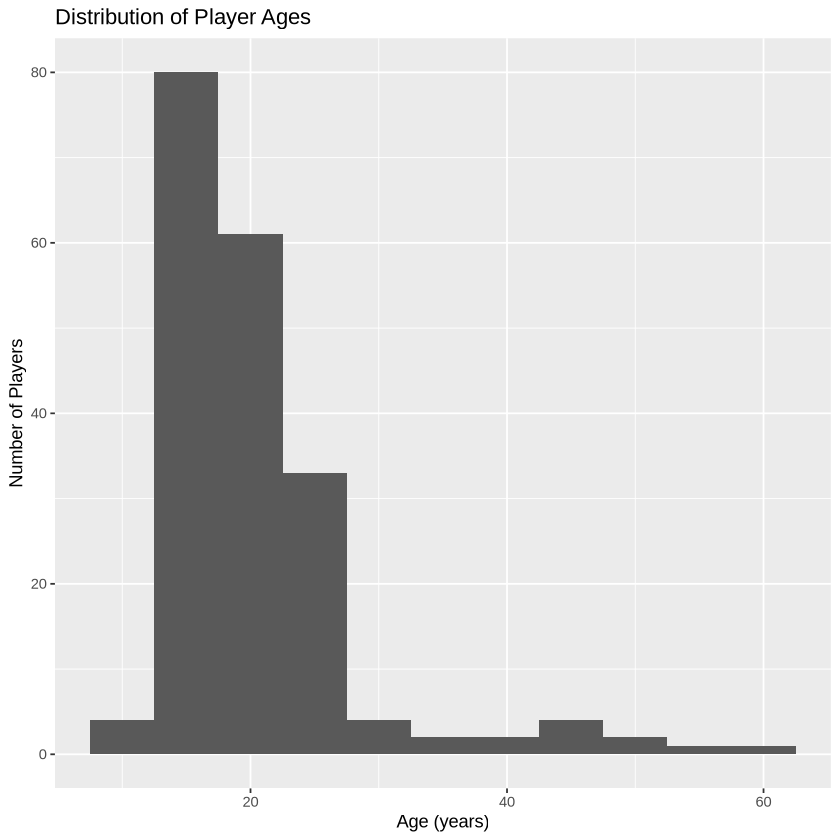

In [60]:
ggplot(players_data, aes(x = Age)) +
  geom_histogram(binwidth = 5) +
  labs(title = "Distribution of Player Ages", x = "Age (years)", y = "Number of Players")

### Figure 3: Distribution of Weekly Hours Played

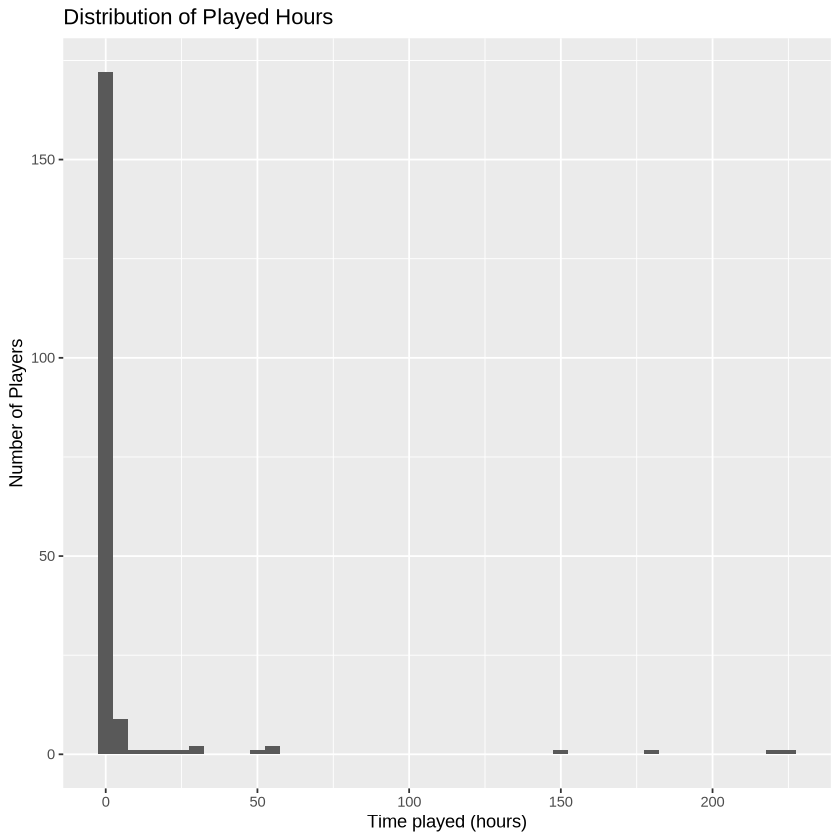

In [66]:
ggplot(players_data, aes(x = played_hours)) +
  geom_histogram(binwidth = 5) +
  labs(title = "Distribution of Played Hours", x = "Time played (hours)", y = "Number of Players")

In [73]:
# Splitting dataset into training and testing
players_split <- initial_split(players_data, prop = 0.7, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

In [90]:
# Training, evaluating, and tuning the model
players_recipe <- recipe(played_hours ~ Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 10, strata = played_hours)

players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)    

gridvals <- tibble (neighbors = seq(from = 1, to = 100, by = 3))

players_results <- players_wkflw |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))

kmin <- players_min |> pull (neighbors)

kmin

[1] 31

In [99]:
# Evaluate on the test set
players_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec2) |>
    fit(data = players_train)

players_preds <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_summary <- players_preds |>
    metrics(truth = played_hours, estimate = .pred) |>
    filter (.metric == "rmse")

players_summary

# results in RMSPE on test data

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,40.06252


### Figure 4: Comparison of Actual and Predicted Hours Played vs Age

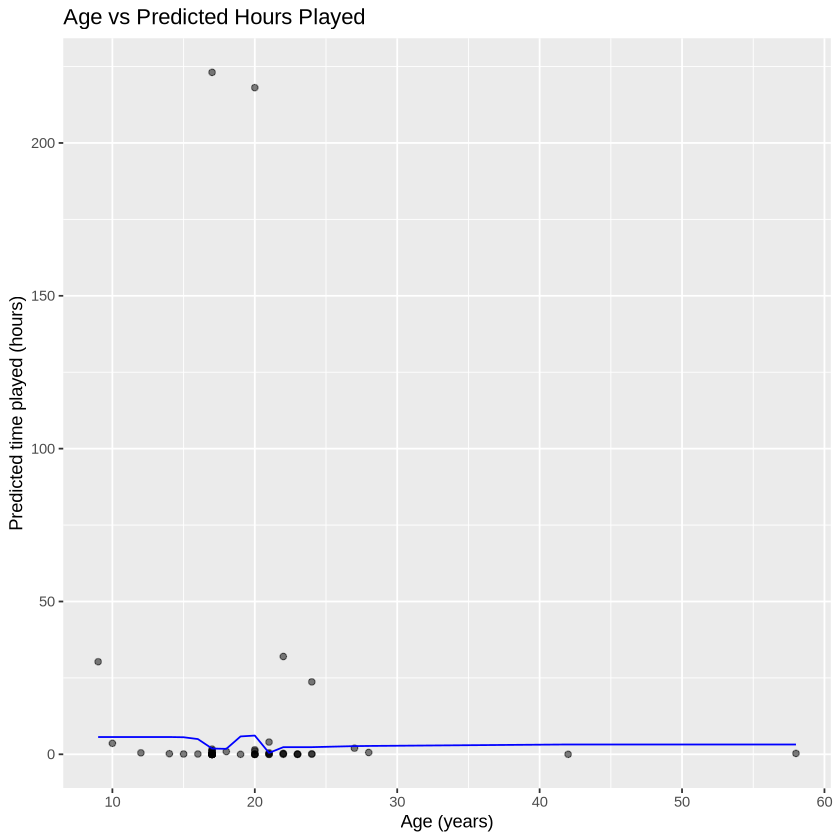

In [105]:
players_plot <- players_preds |>
    ggplot(aes(x=Age, y = played_hours)) +
    geom_point(alpha = 0.5) +
    geom_line(aes(y=.pred), color = "blue") +
    labs(x = "Age (years)", y = "Predicted time played (hours)", title = "Age vs Predicted Hours Played")
    
players_plot